# Create a synthetic data set, store, load, rechunk, store

This [issue](https://github.com/dask/dask/issues/417) may be relevant.

In [1]:
import os
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

zarr_file = os.getenv('SCRATCH')+'/data.zarr'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.start_workers(4)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.110:44038 Dashboard: http://10.148.0.110:8787/status,Cluster Workers: 8 Cores: 32 Memory: 400.00 GB


---

## create a synthetic dataset

<xarray.Dataset>
Dimensions:  (t: 4096, x: 1024, y: 2048)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    v_t      (t) float64 dask.array<shape=(4096,), chunksize=(1,)>
    v_cx     (x) float64 dask.array<shape=(1024,), chunksize=(512,)>
    v_cy     (y) float64 dask.array<shape=(2048,), chunksize=(512,)>
    v        (t, x, y) float64 dask.array<shape=(4096, 1024, 2048), chunksize=(1, 512, 512)>

 data size: 68.7 GB


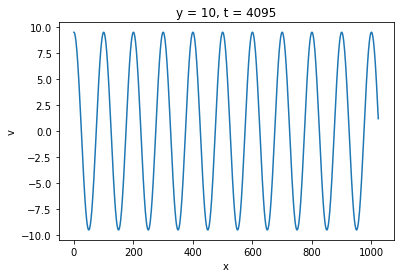

In [10]:
nx, ny, nt = 1024, 1024*2, 1024*4

ds = xr.Dataset({}, coords={'x':np.arange(nx),'y':np.arange(ny), 't': np.arange(nt)})

ds = ds.assign(v_t=np.cos(2.*np.pi*ds.t/100))
ds = ds.assign(v_cx=np.cos(2.*np.pi/100*ds.x))
ds = ds.assign(v_cy=ds.y*1.)

ds = ds.chunk({'t': 1, 'x': nx/2, 'y': ny/4})

ds = ds.assign(v=ds.v_t*ds.v_cx*ds.v_cy)

print(ds)

print('\n data size: %.1f GB' %(ds.v.nbytes / 1e9))

ds.v.isel(t=-1,y=10).plot()

---

## store data

In [11]:
ds.to_zarr(zarr_file, mode='w')

---
## compute a statistical estimate across time

In [27]:
# %time ds.load    # consistently oveload scheduler memory node
#ds = ds.persist()

CPU times: user 1min 33s, sys: 4.16 s, total: 1min 37s
Wall time: 4min 9s


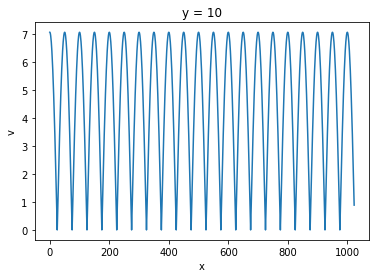

In [31]:
%time ds.v.std(dim='t').isel(y=10).plot()
# selection after computation is intentional
# does not go through if persist is uncommented in previous cell

---

## rechunk (in memory)

In [12]:
#ds = ds.chunk({'t': len(ds.t), 'x': 64, 'y': 64})
#%time ds.load()
# never returns the hand
#
ds = ds.chunk({'t': len(ds.t), 'x': 64, 'y': 64}).persist() 
# requires up to 125-130GB of memory, i.e. about twice the data size

CPU times: user 312 ms, sys: 16 ms, total: 328 ms
Wall time: 913 ms


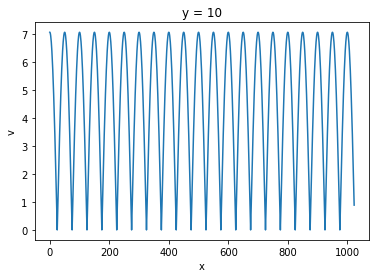

In [13]:
%time ds.v.std(dim='t').isel(y=10).plot()
# (selection after computation is intentional)

---

## load and rechunk

In [16]:
ds = xr.open_zarr(zarr_file)
print(ds)

<xarray.Dataset>
Dimensions:  (t: 4096, x: 1024, y: 2048)
Coordinates:
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    v        (t, x, y) float64 dask.array<shape=(4096, 1024, 2048), chunksize=(1, 512, 512)>
    v_cx     (x) float64 dask.array<shape=(1024,), chunksize=(512,)>
    v_cy     (y) float64 dask.array<shape=(2048,), chunksize=(512,)>
    v_t      (t) float64 dask.array<shape=(4096,), chunksize=(1,)>


In [17]:
ds = ds.chunk({'t': len(ds.t), 'x': 64, 'y': 64}).persist()

CPU times: user 284 ms, sys: 4 ms, total: 288 ms
Wall time: 1.22 s


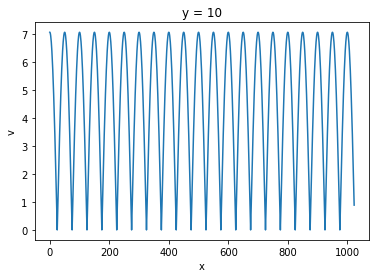

In [18]:
%time ds.v.std(dim='t').isel(y=10).plot()

CPU times: user 18.5 s, sys: 972 ms, total: 19.4 s
Wall time: 42.6 s


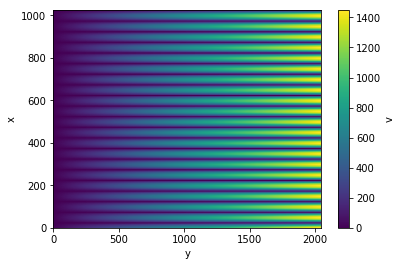

In [19]:
%time ds.v.std(dim='t').plot()

---

In [ ]:
#from dask.dot import dot_graph
#dot_graph(ds['v'].dask)
#dict(ds['v'].data.dask)

---

In [20]:
cluster.scheduler.close()

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>

In [ ]:
client.restart()

In [37]:
del ds